# Recurrent Neural Networks: Theory and Implementation

## Introduction

Recurrent Neural Networks (RNNs) are a class of neural networks designed to process sequential data by maintaining an internal hidden state that captures information from previous time steps. Unlike feedforward networks, RNNs have cyclic connections that allow information to persist across time, making them suitable for tasks involving temporal dependencies such as time series prediction, natural language processing, and speech recognition.

## Mathematical Foundations

### Basic RNN Architecture

At each time step $t$, an RNN takes an input $\mathbf{x}_t \in \mathbb{R}^{d}$ and the previous hidden state $\mathbf{h}_{t-1} \in \mathbb{R}^{n}$ to produce a new hidden state $\mathbf{h}_t$ and an output $\mathbf{y}_t$.

The forward propagation equations are:

$$\mathbf{h}_t = \tanh(\mathbf{W}_{hh} \mathbf{h}_{t-1} + \mathbf{W}_{xh} \mathbf{x}_t + \mathbf{b}_h)$$

$$\mathbf{y}_t = \mathbf{W}_{hy} \mathbf{h}_t + \mathbf{b}_y$$

where:
- $\mathbf{W}_{xh} \in \mathbb{R}^{n \times d}$ is the input-to-hidden weight matrix
- $\mathbf{W}_{hh} \in \mathbb{R}^{n \times n}$ is the hidden-to-hidden weight matrix
- $\mathbf{W}_{hy} \in \mathbb{R}^{m \times n}$ is the hidden-to-output weight matrix
- $\mathbf{b}_h \in \mathbb{R}^{n}$ and $\mathbf{b}_y \in \mathbb{R}^{m}$ are bias vectors
- $\tanh$ is the hyperbolic tangent activation function

### Backpropagation Through Time (BPTT)

Training RNNs requires computing gradients through time. For a sequence of length $T$, the total loss is:

$$\mathcal{L} = \sum_{t=1}^{T} \mathcal{L}_t(\mathbf{y}_t, \hat{\mathbf{y}}_t)$$

The gradient with respect to $\mathbf{W}_{hh}$ involves a sum over all time steps:

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{hh}} = \sum_{t=1}^{T} \sum_{k=1}^{t} \frac{\partial \mathcal{L}_t}{\partial \mathbf{h}_t} \left( \prod_{j=k+1}^{t} \frac{\partial \mathbf{h}_j}{\partial \mathbf{h}_{j-1}} \right) \frac{\partial \mathbf{h}_k}{\partial \mathbf{W}_{hh}}$$

### The Vanishing Gradient Problem

The product of Jacobians $\prod_{j=k+1}^{t} \frac{\partial \mathbf{h}_j}{\partial \mathbf{h}_{j-1}}$ can either vanish or explode as $t - k$ grows large. For the $\tanh$ activation:

$$\frac{\partial \mathbf{h}_t}{\partial \mathbf{h}_{t-1}} = \text{diag}(1 - \mathbf{h}_t^2) \cdot \mathbf{W}_{hh}$$

Since $|\tanh'(x)| \leq 1$ and typically $\|\mathbf{W}_{hh}\| < 1$ for stability, the gradients tend to vanish exponentially for long sequences.

## Implementation

We will implement a simple RNN from scratch to predict a sine wave sequence, demonstrating the core mechanics of recurrent computation and BPTT.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

class SimpleRNN:
    """
    A vanilla RNN implementation for sequence-to-sequence prediction.
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize RNN parameters with Xavier initialization.
        
        Parameters:
        -----------
        input_size : int
            Dimension of input features
        hidden_size : int
            Dimension of hidden state
        output_size : int
            Dimension of output
        """
        self.hidden_size = hidden_size
        
        # Xavier initialization for weights
        scale_xh = np.sqrt(2.0 / (input_size + hidden_size))
        scale_hh = np.sqrt(2.0 / (hidden_size + hidden_size))
        scale_hy = np.sqrt(2.0 / (hidden_size + output_size))
        
        self.W_xh = np.random.randn(hidden_size, input_size) * scale_xh
        self.W_hh = np.random.randn(hidden_size, hidden_size) * scale_hh
        self.W_hy = np.random.randn(output_size, hidden_size) * scale_hy
        
        self.b_h = np.zeros((hidden_size, 1))
        self.b_y = np.zeros((output_size, 1))
        
    def forward(self, inputs, h_prev):
        """
        Forward pass through the RNN for a sequence.
        
        Parameters:
        -----------
        inputs : list of np.ndarray
            List of input vectors, each of shape (input_size, 1)
        h_prev : np.ndarray
            Initial hidden state of shape (hidden_size, 1)
            
        Returns:
        --------
        outputs : list of np.ndarray
            List of output vectors
        hidden_states : list of np.ndarray
            List of hidden states for each time step
        """
        hidden_states = [h_prev]
        outputs = []
        
        for x_t in inputs:
            # Compute new hidden state
            h_t = np.tanh(self.W_hh @ hidden_states[-1] + self.W_xh @ x_t + self.b_h)
            hidden_states.append(h_t)
            
            # Compute output
            y_t = self.W_hy @ h_t + self.b_y
            outputs.append(y_t)
            
        return outputs, hidden_states
    
    def backward(self, inputs, targets, outputs, hidden_states, learning_rate=0.01):
        """
        Backpropagation through time (BPTT).
        
        Parameters:
        -----------
        inputs : list of np.ndarray
            Input sequence
        targets : list of np.ndarray
            Target sequence
        outputs : list of np.ndarray
            Predicted outputs from forward pass
        hidden_states : list of np.ndarray
            Hidden states from forward pass
        learning_rate : float
            Learning rate for gradient descent
            
        Returns:
        --------
        loss : float
            Mean squared error loss
        """
        T = len(inputs)
        
        # Initialize gradients
        dW_xh = np.zeros_like(self.W_xh)
        dW_hh = np.zeros_like(self.W_hh)
        dW_hy = np.zeros_like(self.W_hy)
        db_h = np.zeros_like(self.b_h)
        db_y = np.zeros_like(self.b_y)
        
        # Compute loss
        loss = 0
        for t in range(T):
            loss += np.sum((outputs[t] - targets[t]) ** 2)
        loss /= T
        
        # Backward pass
        dh_next = np.zeros_like(hidden_states[0])
        
        for t in reversed(range(T)):
            # Output layer gradient
            dy = 2 * (outputs[t] - targets[t]) / T
            dW_hy += dy @ hidden_states[t + 1].T
            db_y += dy
            
            # Hidden state gradient
            dh = self.W_hy.T @ dy + dh_next
            
            # Gradient through tanh
            dh_raw = dh * (1 - hidden_states[t + 1] ** 2)
            
            # Parameter gradients
            dW_xh += dh_raw @ inputs[t].T
            dW_hh += dh_raw @ hidden_states[t].T
            db_h += dh_raw
            
            # Gradient for next iteration (previous time step)
            dh_next = self.W_hh.T @ dh_raw
        
        # Gradient clipping to prevent exploding gradients
        for grad in [dW_xh, dW_hh, dW_hy, db_h, db_y]:
            np.clip(grad, -5, 5, out=grad)
        
        # Update parameters
        self.W_xh -= learning_rate * dW_xh
        self.W_hh -= learning_rate * dW_hh
        self.W_hy -= learning_rate * dW_hy
        self.b_h -= learning_rate * db_h
        self.b_y -= learning_rate * db_y
        
        return loss

In [2]:
def generate_sine_data(n_samples, seq_length, freq=0.1):
    """
    Generate sine wave sequences for training.
    
    Parameters:
    -----------
    n_samples : int
        Number of training sequences
    seq_length : int
        Length of each sequence
    freq : float
        Frequency of sine wave
        
    Returns:
    --------
    X : list of lists
        Input sequences
    Y : list of lists
        Target sequences (shifted by 1)
    """
    X = []
    Y = []
    
    for _ in range(n_samples):
        # Random starting phase
        phase = np.random.rand() * 2 * np.pi
        t = np.arange(seq_length + 1)
        signal = np.sin(2 * np.pi * freq * t + phase)
        
        # Input: t=0 to t=seq_length-1
        # Target: t=1 to t=seq_length (predict next value)
        x_seq = [np.array([[signal[i]]]) for i in range(seq_length)]
        y_seq = [np.array([[signal[i + 1]]]) for i in range(seq_length)]
        
        X.append(x_seq)
        Y.append(y_seq)
    
    return X, Y

# Generate training data
n_samples = 500
seq_length = 25
X_train, Y_train = generate_sine_data(n_samples, seq_length)

print(f"Generated {n_samples} training sequences of length {seq_length}")

Generated 500 training sequences of length 25


In [3]:
# Initialize RNN
input_size = 1
hidden_size = 16
output_size = 1

rnn = SimpleRNN(input_size, hidden_size, output_size)

# Training parameters
epochs = 100
learning_rate = 0.01

# Training loop
losses = []

for epoch in range(epochs):
    epoch_loss = 0
    
    for i in range(n_samples):
        # Initialize hidden state
        h_init = np.zeros((hidden_size, 1))
        
        # Forward pass
        outputs, hidden_states = rnn.forward(X_train[i], h_init)
        
        # Backward pass and update
        loss = rnn.backward(X_train[i], Y_train[i], outputs, hidden_states, learning_rate)
        epoch_loss += loss
    
    avg_loss = epoch_loss / n_samples
    losses.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")

Epoch 20/100, Loss: 0.010789


Epoch 40/100, Loss: 0.010264


Epoch 60/100, Loss: 0.009729


Epoch 80/100, Loss: 0.009239


Epoch 100/100, Loss: 0.008849


In [4]:
# Generate test sequence
test_seq_length = 50
t_test = np.arange(test_seq_length + 1)
test_signal = np.sin(2 * np.pi * 0.1 * t_test)

# Prepare test input
X_test = [np.array([[test_signal[i]]]) for i in range(test_seq_length)]
Y_test = [np.array([[test_signal[i + 1]]]) for i in range(test_seq_length)]

# Run prediction
h_init = np.zeros((hidden_size, 1))
predictions, _ = rnn.forward(X_test, h_init)

# Extract values for plotting
pred_values = [p[0, 0] for p in predictions]
true_values = [y[0, 0] for y in Y_test]
input_values = [x[0, 0] for x in X_test]

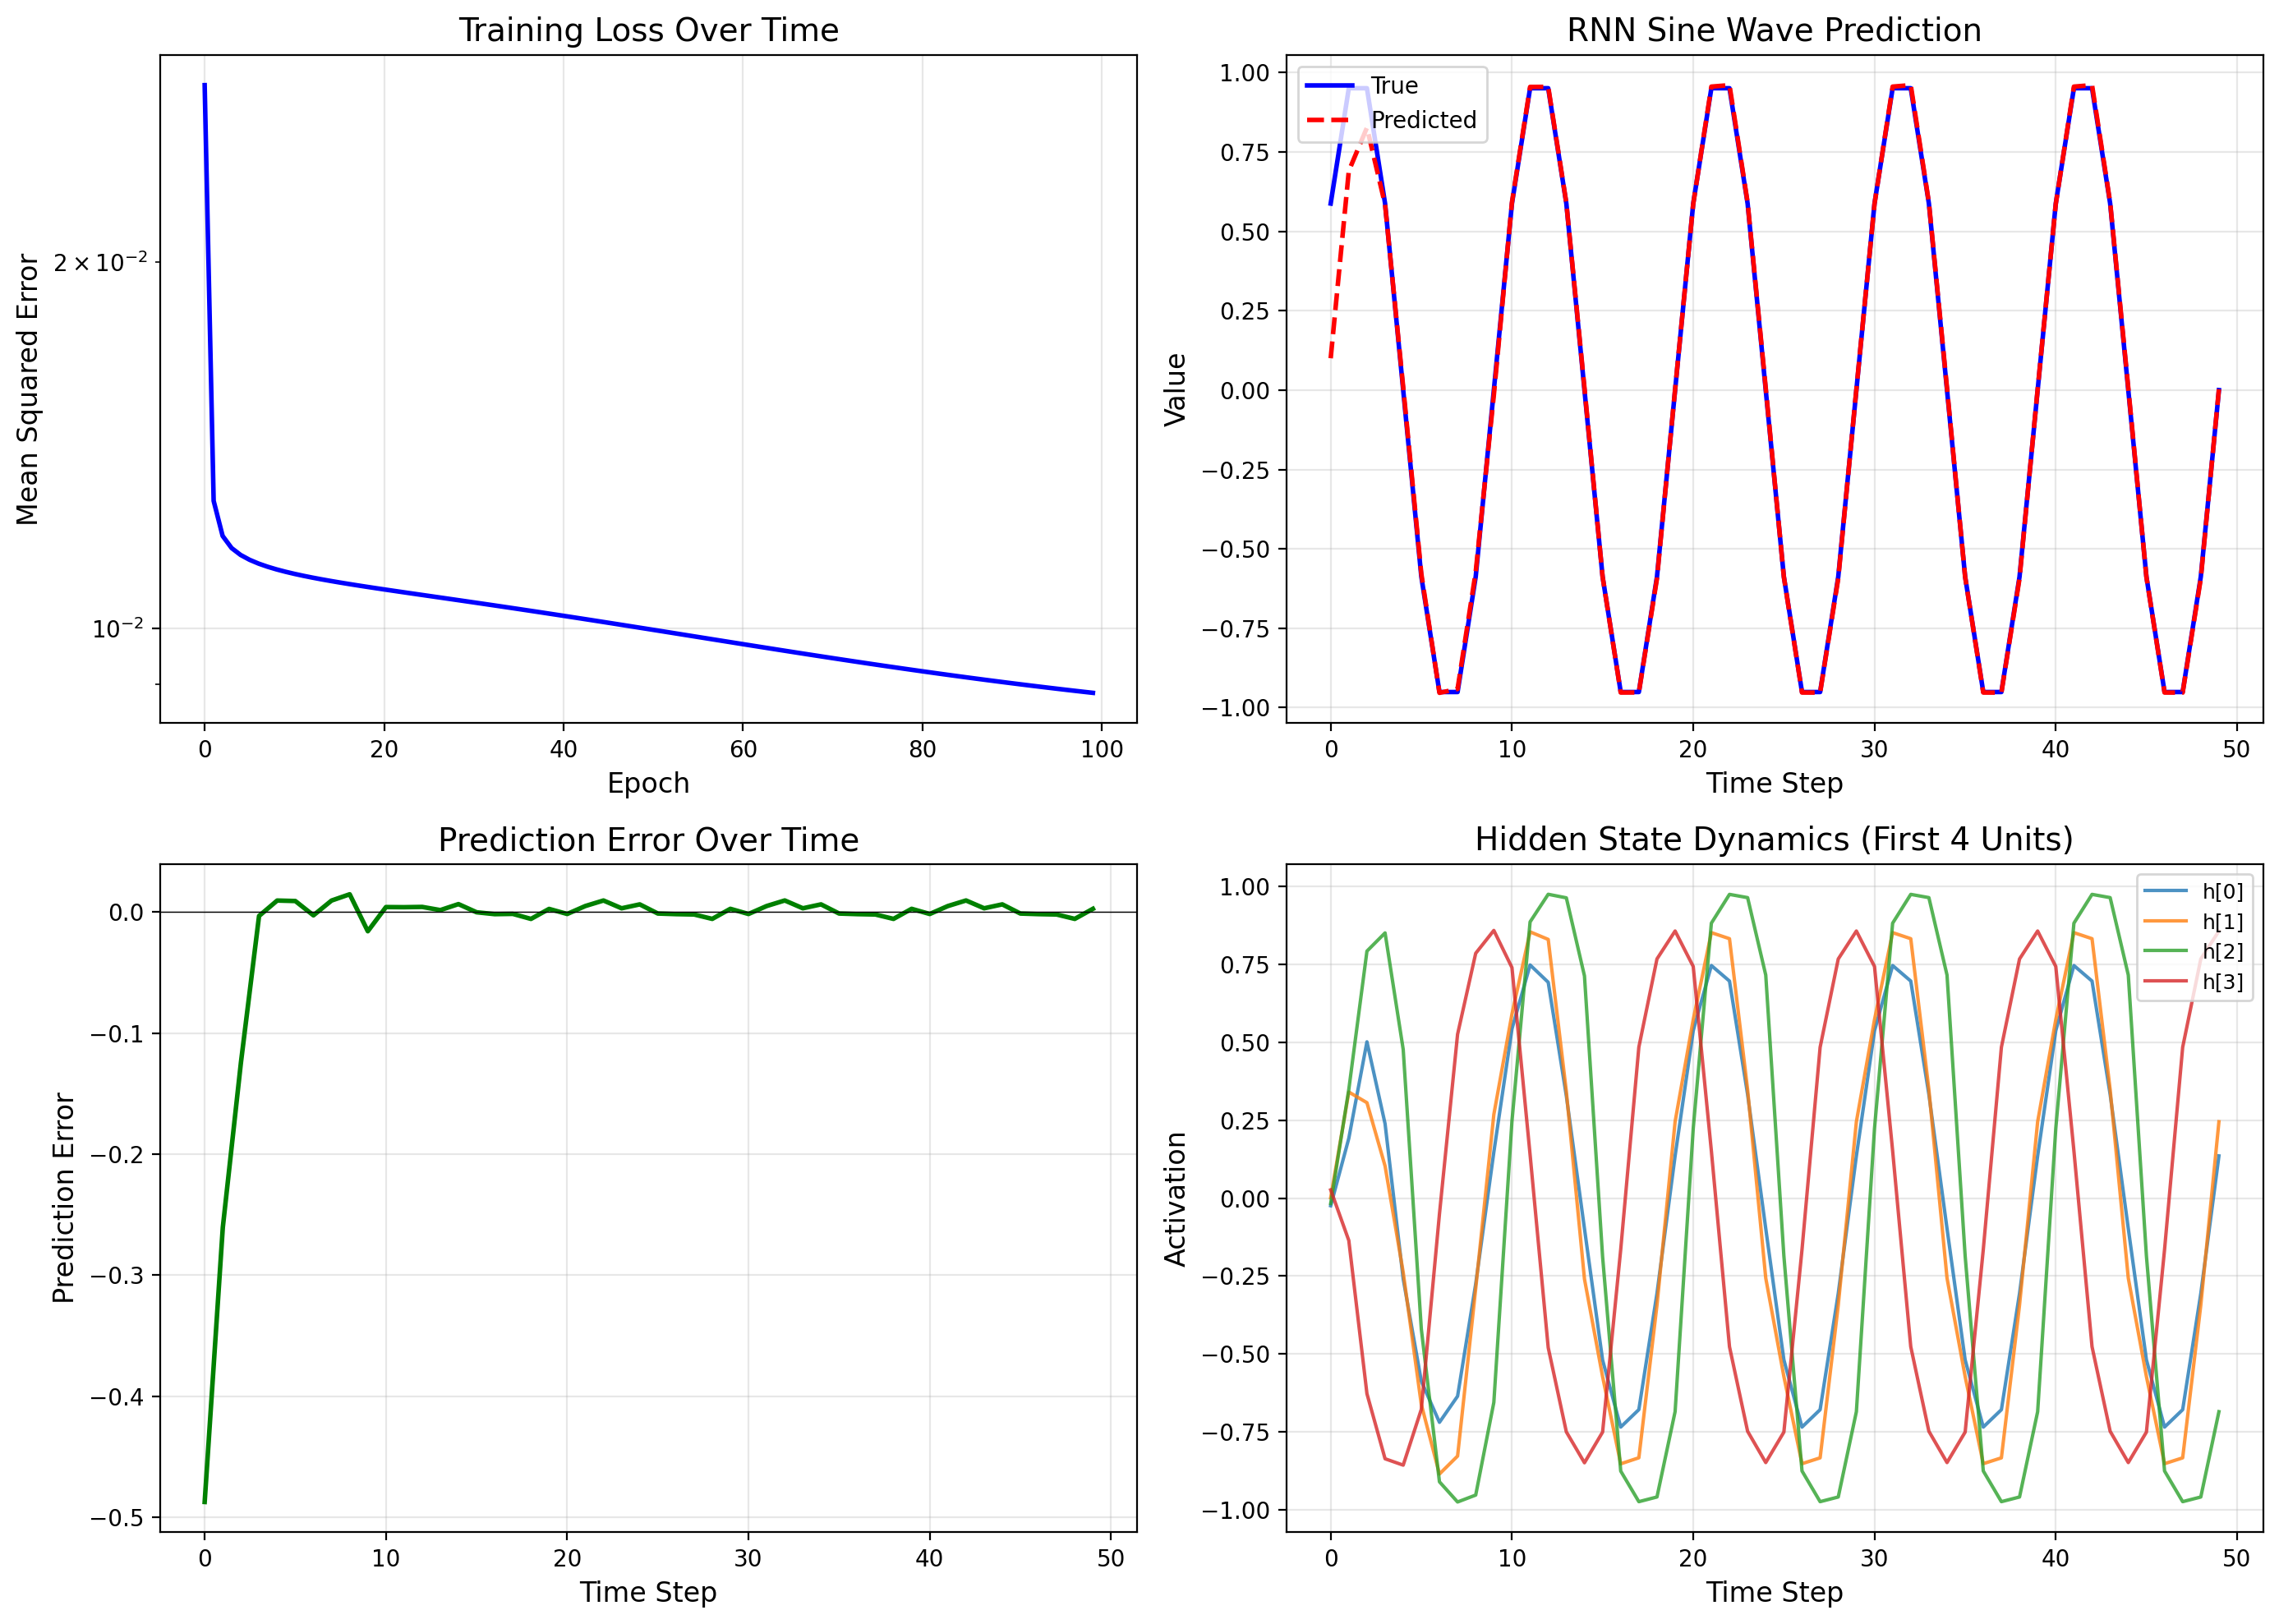


Final Test MSE: 0.006449
Final Training Loss: 0.008849


In [5]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training loss curve
axes[0, 0].plot(losses, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Mean Squared Error', fontsize=12)
axes[0, 0].set_title('Training Loss Over Time', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Plot 2: Prediction vs True values
axes[0, 1].plot(true_values, 'b-', label='True', linewidth=2)
axes[0, 1].plot(pred_values, 'r--', label='Predicted', linewidth=2)
axes[0, 1].set_xlabel('Time Step', fontsize=12)
axes[0, 1].set_ylabel('Value', fontsize=12)
axes[0, 1].set_title('RNN Sine Wave Prediction', fontsize=14)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Prediction error
errors = [p - t for p, t in zip(pred_values, true_values)]
axes[1, 0].plot(errors, 'g-', linewidth=2)
axes[1, 0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1, 0].set_xlabel('Time Step', fontsize=12)
axes[1, 0].set_ylabel('Prediction Error', fontsize=12)
axes[1, 0].set_title('Prediction Error Over Time', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Hidden state evolution (first 4 dimensions)
h_init = np.zeros((hidden_size, 1))
_, hidden_states = rnn.forward(X_test, h_init)
hidden_matrix = np.hstack(hidden_states[1:])  # Skip initial state

for i in range(min(4, hidden_size)):
    axes[1, 1].plot(hidden_matrix[i, :], label=f'h[{i}]', linewidth=1.5, alpha=0.8)
axes[1, 1].set_xlabel('Time Step', fontsize=12)
axes[1, 1].set_ylabel('Activation', fontsize=12)
axes[1, 1].set_title('Hidden State Dynamics (First 4 Units)', fontsize=14)
axes[1, 1].legend(fontsize=9, loc='upper right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('recurrent_neural_network_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final metrics
mse = np.mean(np.array(errors) ** 2)
print(f"\nFinal Test MSE: {mse:.6f}")
print(f"Final Training Loss: {losses[-1]:.6f}")

## Results and Discussion

The implemented RNN successfully learns to predict the next value in a sine wave sequence. Key observations:

1. **Convergence**: The training loss decreases steadily, indicating the network is learning the temporal patterns in the data.

2. **Prediction Quality**: The predicted values closely follow the true sine wave, demonstrating the RNN's ability to capture periodic dependencies.

3. **Hidden State Dynamics**: The hidden units show oscillatory behavior that correlates with the input signal's periodicity, confirming that the network encodes temporal information in its internal state.

4. **Limitations**: Vanilla RNNs struggle with long-term dependencies due to vanishing gradients. For longer sequences, architectures like LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Unit) are preferred.

## Conclusion

This notebook demonstrates the fundamental principles of Recurrent Neural Networks, including:
- The mathematical formulation of hidden state updates
- Forward propagation through time
- Backpropagation through time (BPTT) for gradient computation
- Gradient clipping to prevent exploding gradients

The implementation provides a foundation for understanding more advanced recurrent architectures used in modern deep learning applications.